## Chatbot with multiple tools 

In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [5]:
api_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)

arxiv = ArxivQueryRun(api_wrapper=api_wrapper)

print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [8]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [9]:
!pip install langchain_tavily


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
from langchain_tavily import TavilySearch

tavilytool = TavilySearch(
    max_results=5,
    topic="general",
)

In [15]:
from langchain_core.messages import HumanMessage,AIMessage

In [30]:

llm = ChatGroq(model="Gemma2-9b-It").bind_tools(tools=tools)

In [31]:
llm.invoke([HumanMessage(content="Get some recent indian news")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3t1aksy31', 'function': {'arguments': '{"query":"indian news","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 3158, 'total_tokens': 3249, 'completion_time': 0.165454545, 'prompt_time': 0.064954094, 'queue_time': 0.028695283000000002, 'total_time': 0.230408639}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f3bab021-f19b-4092-85a8-60e16cb8fe25-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'indian news', 'topic': 'news'}, 'id': '3t1aksy31', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3158, 'output_tokens': 91, 'total_tokens': 3249})

In [26]:
toolCalls = llm.invoke([HumanMessage(content="Get some recent indian news")]).tool_calls
toolCalls

[{'name': 'tavily_search',
  'args': {'query': 'indian news', 'topic': 'news'},
  'id': 'fj76gfb9m',
  'type': 'tool_call'}]

In [27]:
from langgraph.graph import StateGraph, START,END
from langchain_core.messages import BaseMessage,HumanMessage,ToolMessage,SystemMessage,AnyMessage
from langchain_core.tools import tool
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from typing import TypedDict,Annotated,Sequence

class AgentState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [42]:
@tool
def add(a,b):
    """This is used to add 2 numbers and returns their sum"""
    return a+b
@tool
def mul(a,b):
    """This is used to multiply 2 numbers and returns their product value"""
    return a*b

tools = [arxiv,tavilytool,add,mul]
tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearch(max_results=5, topic='general', api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None)),
 StructuredTool(name='add', description='This is used to add 2 numbers and returns their sum', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x120513100>),
 StructuredTool(name='mul', description='This is used to multiply 2 numbers and returns their product value', args_schema=<class 'langchain_core.utils.pydantic.mul'>, func=<function mul at 0x1204db380>)]

In [45]:
def llm_that_calls_tools(state:AgentState):

    return {"messages":llm.invoke(state["messages"])}

graph = StateGraph(AgentState)
graph.add_node("LLM_with_capabilities",llm_that_calls_tools)
graph.add_node("tools",ToolNode(tools))
graph.set_entry_point("LLM_with_capabilities")
graph.add_conditional_edges(
    "LLM_with_capabilities",
    tools_condition,
)
graph.add_edge("tools",END)
build = graph.compile()

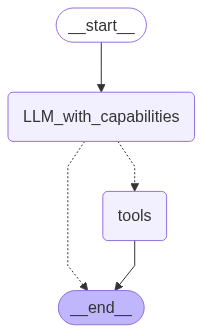

In [46]:
from IPython.display import display,Image
display(Image(build.get_graph().draw_mermaid_png()))

In [50]:
user = build.invoke({"messages":HumanMessage(content="Get me some recent indian news")})

for m in user["messages"]:
    m.pretty_print()

================================ Human Message =================================

Get me some recent indian news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (vrmgayeyp)
 Call ID: vrmgayeyp
  Args:
    query: indian news
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "indian news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.indiatoday.in/", "title": "India Today: Latest News, Breaking News Today - Entertainment ...", "content": "Check out the latest news from India and around the world. Latest India news on Bollywood, Politics, Business, Cricket, Technology and Travel.", "score": 0.6737291, "raw_content": null}, {"url": "https://indianexpress.com/international/", "title": "International News - The Indian Express", "content": "International News: Latest News Today, International Headlines and Top